In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.base import BaseEstimator, ClassifierMixin
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions import Normal

class TorchMultivariateGaussianClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, class_params=None, device="cpu"):
        """
        Initialize the classifier with class parameters.

        Parameters:
        class_params: dict
            A dictionary where keys are class labels and values are dictionaries with
            'mean' (vector), 'cov' (matrix), and 'prior' for each class.
        device: str
            The device to use for computations ('cpu' or 'cuda').
        """
        self.class_params = class_params if class_params is not None else {}
        self.device = torch.device(device)
        self.classes_ = torch.tensor(list(self.class_params.keys()), device=self.device)
        self.n_features = len(self.class_params[0]["cov"])
        self.n_classes = len(self.classes_)
    
    def fit(self, X, y=None):
        """
        Fit method for compatibility. This classifier doesn't require fitting.
        """
        self.classes_ = torch.tensor(list(self.class_params.keys()), device=self.device)
        return self
    
    def predict_proba(self, X):
        """
        Predict the probability of each class for the given input data X.

        Parameters:
        X: torch.Tensor or array-like of shape (n_samples, n_features)
            Input features.

        Returns:
        probs: torch.Tensor of shape (n_samples, n_classes)
            Predicted probabilities for each class.
        """
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X, device=self.device, dtype=torch.float32)
        
        probs = torch.zeros((X.shape[0], len(self.classes_)), device=self.device)
        for i, c in enumerate(self.classes_):
            mean = torch.tensor(self.class_params[int(c)]["mean"], device=self.device, dtype=torch.float32)
            cov = torch.tensor(self.class_params[int(c)]["cov"], device=self.device, dtype=torch.float32)
            prior = self.class_params[int(c)]["prior"]
            
            # Multivariate normal distribution
            mvn_dist = MultivariateNormal(mean, covariance_matrix=cov)
            px_given_y = torch.exp(mvn_dist.log_prob(X))
            
            # Combine with prior
            probs[:, i] = px_given_y * prior
        
        # Normalize to get P(y=c|x)
        probs /= probs.sum(dim=1, keepdim=True)
        return probs
    
    def predict(self, X):
        """
        Predict the class label for each sample in X.

        Parameters:
        X: torch.Tensor or array-like of shape (n_samples, n_features)
            Input features.

        Returns:
        predictions: torch.Tensor of shape (n_samples,)
            Predicted class labels.
        """
        probs = self.predict_proba(X)
        return self.classes_[torch.argmax(probs, dim=1)]
    
    def generate_data(self, n_samples=100):
        """
        Generate synthetic data using the predefined class parameters.

        Parameters:
        n_samples: int
            Number of samples to generate.

        Returns:
        X: torch.Tensor of shape (n_samples, n_features)
            Generated features.
        y: torch.Tensor of shape (n_samples,)
            Generated labels.
        """
        X = []
        y = []
        for _ in range(n_samples):
            # Sample class based on priors
            sampled_class = torch.multinomial(
                torch.tensor([self.class_params[int(c)]["prior"] for c in self.classes_], device=self.device),
                num_samples=1
            ).item()
            mean = torch.tensor(self.class_params[int(self.classes_[sampled_class])]["mean"], device=self.device, dtype=torch.float32)
            cov = torch.tensor(self.class_params[int(self.classes_[sampled_class])]["cov"], device=self.device, dtype=torch.float32)
            
            # Sample feature vector from the corresponding multivariate Gaussian
            mvn_dist = MultivariateNormal(mean, covariance_matrix=cov)
            sampled_x = mvn_dist.sample()
            X.append(sampled_x)
            y.append(self.classes_[sampled_class].item())
        
        return torch.stack(X), torch.tensor(y, device=self.device)

class TorchGaussianSyntheticClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, class_params=None, device="cpu"):
        """
        Initialize the classifier with class parameters.

        Parameters:
        class_params: dict
            A dictionary where keys are class labels and values are dictionaries with
            'mean', 'std', and 'prior' for each class.
        device: str
            The device to use for computations ('cpu' or 'cuda').
        """
        self.class_params = class_params if class_params is not None else {}
        self.device = torch.device(device)
        self.classes_ = torch.tensor(list(self.class_params.keys()), device=self.device)
        self.n_features = 1
        self.n_classes = len(self.classes_)
    
    def fit(self, X, y=None):
        """
        Fit method for compatibility. This classifier doesn't require fitting.
        """
        self.classes_ = torch.tensor(list(self.class_params.keys()), device=self.device)
        return self
    
    def predict_proba(self, X):
        """
        Predict the probability of each class for the given input data X.

        Parameters:
        X: torch.Tensor or array-like of shape (n_samples,)
            Input features.

        Returns:
        probs: torch.Tensor of shape (n_samples, n_classes)
            Predicted probabilities for each class.
        """
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X, device=self.device, dtype=torch.float32)
        
        probs = torch.zeros((len(X), len(self.classes_)), device=self.device)
        for i, c in enumerate(self.classes_):
            mean = self.class_params[int(c)]["mean"]
            std = self.class_params[int(c)]["std"]
            prior = self.class_params[int(c)]["prior"]
            
            # Calculate Gaussian PDF: P(x|y=c)
            normal_dist = Normal(loc=mean, scale=std)
            px_given_y = torch.exp(normal_dist.log_prob(X))
            
            # Combine with prior: P(x|y=c) * P(y=c)
            probs[:, i] = px_given_y * prior
        
        # Normalize to get P(y=c|x)
        probs /= probs.sum(dim=1, keepdim=True)
        return probs
    
    def predict(self, X):
        """
        Predict the class label for each sample in X.

        Parameters:
        X: torch.Tensor or array-like of shape (n_samples,)
            Input features.

        Returns:
        predictions: torch.Tensor of shape (n_samples,)
            Predicted class labels.
        """
        probs = self.predict_proba(X)
        return self.classes_[torch.argmax(probs, dim=1)]

    def generate_data(self, n_samples=100):
        """
        Generate synthetic data using the predefined class parameters.

        Parameters:
        n_samples: int
            Number of samples to generate.

        Returns:
        X: torch.Tensor of shape (n_samples,)
            Generated features.
        y: torch.Tensor of shape (n_samples,)
            Generated labels.
        """
        X = []
        y = []
        for _ in range(n_samples):
            # Sample class based on priors
            sampled_class = torch.multinomial(
                torch.tensor([self.class_params[int(c)]["prior"] for c in self.classes_], device=self.device),
                num_samples=1
            ).item()
            # Sample feature value from the corresponding Gaussian
            mean = self.class_params[int(self.classes_[sampled_class])]["mean"]
            std = self.class_params[int(self.classes_[sampled_class])]["std"]
            normal_dist = Normal(loc=mean, scale=std)
            sampled_x = normal_dist.sample().item()
            X.append(sampled_x)
            y.append(self.classes_[sampled_class].item())
        
        return torch.tensor(X, device=self.device), torch.tensor(y, device=self.device)

def goodman_kruskal_gamma(x, y):
    """
    Compute Goodman and Kruskal's Gamma for two ordinal variables.
    
    Parameters:
    x, y: Lists or arrays of ordinal data (same length)
    
    Returns:
    gamma: Goodman and Kruskal's Gamma
    """
    if len(x) != len(y):
        raise ValueError("Both variables must have the same length.")
    
    concordant = 0
    discordant = 0
    
    n = len(x)
    for i in range(n - 1):
        for j in range(i + 1, n):
            # Determine concordance or discordance
            if (x[i] > x[j] and y[i] > y[j]) or (x[i] < x[j] and y[i] < y[j]):
                concordant += 1
            elif (x[i] > x[j] and y[i] < y[j]) or (x[i] < x[j] and y[i] > y[j]):
                discordant += 1
    
    # Compute Gamma
    if concordant + discordant == 0:
        return 0  # Avoid division by zero
    gamma = (concordant - discordant) / (concordant + discordant)
    return gamma

from torchcp.classification.score import APS, THR
aps = APS(score_type="identity", randomized=False)
lac = THR(score_type="identity",)
score = aps

class_params_1f_2c = {
    0: {"mean": 1, "std": 1, "prior": 0.3},
    1: {"mean": 3, "std": 1, "prior": 0.4},
    # 2: {"mean": 4, "std": 2.2, "prior": 0.3},
}   

class_params_1f_3c = {
    0: {"mean": 1, "std": 1, "prior": 0.3},
    1: {"mean": 3, "std": 1, "prior": 0.4},
    2: {"mean": 4, "std": 2.2, "prior": 0.3},
}   

# Initialize and fit the generator
class_params_2d_3c = {
    0: {
        "mean": [3.0, 2.0],  # Mean vector for class 0
        "cov": [
            [1.0, 0.5],
            [0.5, 1.2],
            # [0.3, 0.4, 0.8]
        ],  # Covariance matrix for class 0
        "prior": 0.3  # Prior probability for class 0
    },
    1: {
        "mean": [3.0, 4.0],  # Mean vector for class 1
        "cov": [
            [1.5, 0.3],
            [0.3, 1.1],
            # [0.2, 0.1, 0.9]
        ],  # Covariance matrix for class 1
        "prior": 0.4  # Prior probability for class 1
    },
    2: {
        "mean": [1.0, 2.0],  # Mean vector for class 2
        "cov": [
            [1.2, 0.4],
            [0.4, 1.3],
            # [0.3, 0.5, 1.4]
        ],  # Covariance matrix for class 2
        "prior": 0.3  # Prior probability for class 2
    },
}

# Initialize and fit the generator
class_params_3d_3c = {
    0: {
        "mean": [3.0, 2.0, 4.0],  # Mean vector for class 0
        "cov": [
            [1.0, 0.5, 0.3],
            [0.5, 1.2, 0.4],
            [0.3, 0.4, 0.8]
        ],  # Covariance matrix for class 0
        "prior": 0.3  # Prior probability for class 0
    },
    1: {
        "mean": [3.0, 4.0, 1.0],  # Mean vector for class 1
        "cov": [
            [1.5, 0.3, 0.2],
            [0.3, 1.1, 0.1],
            [0.2, 0.1, 0.9]
        ],  # Covariance matrix for class 1
        "prior": 0.4  # Prior probability for class 1
    },
    2: {
        "mean": [1.0, 2.0, 2.0],  # Mean vector for class 2
        "cov": [
            [1.2, 0.4, 0.3],
            [0.4, 1.3, 0.5],
            [0.3, 0.5, 1.4]
        ],  # Covariance matrix for class 2
        "prior": 0.3  # Prior probability for class 2
    },
}


# Initialize and fit the generator
class_params_2d_2c = {
    0: {
        "mean": [3.0, 2.0],  # Mean vector for class 0
        "cov": [
            [1.0, 0.5],
            [0.5, 1.2],
        ],  # Covariance matrix for class 0
        "prior": 0.3  # Prior probability for class 0
    },
    1: {
        "mean": [2.0, 3.0],  # Mean vector for class 1
        "cov": [
            [1.5, 0.3],
            [0.3, 1.1],
        ],  # Covariance matrix for class 1
        "prior": 0.4  # Prior probability for class 1
    },
    # 2: {
    #     "mean": [1.0, 2.0, 2.0],  # Mean vector for class 2
    #     "cov": [
    #         [1.2, 0.4],
    #         [0.4, 1.3],
    #         # [0.3, 0.5, 1.4]
    #     ],  # Covariance matrix for class 2
    #     "prior": 0.3  # Prior probability for class 2
    # },
}

clf_1d_2c = TorchGaussianSyntheticClassifier(class_params=class_params_1f_2c, device="cpu")
clf_1d_3c = TorchGaussianSyntheticClassifier(class_params=class_params_1f_3c, device="cpu")
clf_3d_3c = TorchMultivariateGaussianClassifier(class_params=class_params_3d_3c, device="cpu")
clf_2d_2c = TorchMultivariateGaussianClassifier(class_params=class_params_2d_2c, device="cpu")

/home/jonas/anaconda3/envs/plnet/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class OracleAnnotator:
    def __init__(self,score, generator):
        self.score = score
        self.classes_ = generator.classes_
        self.generator = generator

    # we assume y is already label encoded
    def get_conformity(self, X, y):
        y_pred_proba = self.generator.predict_proba(X)
        scores = self.score(y_pred_proba, y)
        return scores

In [71]:
from mapie.classification import MapieClassifier
from mapie.conformity_scores.sets import APSConformityScore, LACConformityScore, NaiveConformityScore, TopKConformityScore
from util.ranking_datasets import LabelPairDataset
from models.ranking_models import LabelRankingModel
from torch.utils.data.dataloader import DataLoader
from sklearn.datasets import make_classification
from scipy.stats import kendalltau
import matplotlib.pyplot as plt
from models.ranking_models import SortLayer
import torch

def fit_model_with_all_pairs(X_train, y_train, oracle_annotator, generator, learning_rate = 0.01, num_epochs=200):
    conformities = oracle_annotator.get_conformity(torch.tensor(X_train),torch.tensor(y_train)).detach().numpy()

    unique_elements, counts = np.unique(conformities, return_counts=True)
    non_unique_elements = unique_elements[counts > 1]
    non_unique_indices = np.where(np.isin(conformities, non_unique_elements))[0]
    mask = np.ones(conformities.shape, dtype=bool)  # Start with all True
    mask[non_unique_indices] = False       # Set False for non-unique indices


    X_train = X_train[mask]
    y_train = y_train[mask]
    conformities = conformities[mask]

    sort_idx = (-conformities).argsort(axis=0).flatten()
    X_sorted = X_train[sort_idx]
    y_sorted = y_train[sort_idx]

    
    X_pairs = np.array([(X_sorted[i], X_sorted[j]) for i in range(len(X_sorted)) for j in range(i + 1, len(X_sorted))])
    y_pairs = np.array([(y_sorted[i], y_sorted[j]) for i in range(len(y_sorted)) for j in range(i + 1, len(y_sorted))])
    y_pairs = np.expand_dims(y_pairs,axis=-1)




    ds = LabelPairDataset()
    ds.create_from_numpy_pairs(X_pairs, y_pairs)
    pair_loader = DataLoader(ds, batch_size=64)
    # ds_val = LabelPairDataset()
    # ds_val.create_from_numpy_pairs(X_pairs, y_pairs)
    # val_loader = DataLoader(ds_val, batch_size=64)
    model = LabelRankingModel(input_dim=generator.n_features, hidden_dims=2*[15*generator.n_features], output_dim=len(generator.classes_))
    model.num_classes = generator.n_classes
    device = next(model.parameters()).device
    model._fit(pair_loader, val_loader=None, num_epochs=num_epochs, learning_rate=learning_rate, patience=num_epochs, verbose=True)
    return model

def conduct_oracle_experiment(score, num_instances_to_check, generator):
    tau_corrs = []
    gamma_corrs = []
    # Generate a small dataset
    # create 
    oracle_annotator = OracleAnnotator(generator=generator, score=score)
    models = []

    for num_instances in num_instances_to_check:
        X_gen, _ = generator.generate_data(n_samples=num_instances)
        X_train = X_gen.repeat_interleave(generator.n_classes, dim=0)
        y_train = np.tile(generator.classes_, num_instances)

        model = fit_model_with_all_pairs(X_train, y_train, oracle_annotator, generator)

        # generate data from data generating process and check whether the learned non-conformity relation sorts them correctly
        X_test, y_test = generator.generate_data(n_samples=100)
        # X_test = X_gen.repeat_interleave(3, dim=0)
        # y_test = np.tile(generator.classes_, 100)
        skills_from_model = np.take_along_axis(model.predict_class_skills(X_test), y_test[:,np.newaxis].detach().numpy(), axis=1)
        conformity_scores = oracle_annotator.get_conformity(torch.tensor(X_test), torch.tensor(y_test))
        tau_corr, p_value = kendalltau(skills_from_model, conformity_scores)
        tau_corrs.append(tau_corr)
        gamma_corr = goodman_kruskal_gamma(skills_from_model,conformity_scores)
        gamma_corrs.append(gamma_corr)
        models.append(model)
    return tau_corrs, gamma_corrs, skills_from_model, conformity_scores, models, X_train, y_train

In [72]:
clf = clf_3d_3c

oracle_annotator_lac = OracleAnnotator(generator=clf, score=lac)
oracle_annotator_aps = OracleAnnotator(generator=clf, score=aps)
num_instances = 50
X_gen, _ = clf.generate_data(n_samples=num_instances)
X_train = X_gen.repeat_interleave(clf.n_classes, dim=0)
y_train = np.tile(clf.classes_, num_instances)

# model_lac = fit_model_with_all_pairs(X_train, y_train, oracle_annotator_lac, clf, learning_rate=0.1,num_epochs=200)
model_aps = fit_model_with_all_pairs(X_train, y_train, oracle_annotator_aps, clf, learning_rate=0.01,num_epochs=1000)

/tmp/ipykernel_315728/2734102823.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conformities = oracle_annotator.get_conformity(torch.tensor(X_train),torch.tensor(y_train)).detach().numpy()


Epoch 1/1000
  Train Loss: 0.0100
Epoch 2/1000
  Train Loss: 0.0099
Epoch 3/1000
  Train Loss: 0.0096
Epoch 4/1000
  Train Loss: 0.0096
Epoch 5/1000
  Train Loss: 0.0093
Epoch 6/1000
  Train Loss: 0.0095
Epoch 7/1000
  Train Loss: 0.0089
Epoch 8/1000
  Train Loss: 0.0084
Epoch 9/1000
  Train Loss: 0.0079
Epoch 10/1000
  Train Loss: 0.0074
Epoch 11/1000
  Train Loss: 0.0070
Epoch 12/1000
  Train Loss: 0.0067
Epoch 13/1000
  Train Loss: 0.0064
Epoch 14/1000
  Train Loss: 0.0062
Epoch 15/1000
  Train Loss: 0.0059
Epoch 16/1000
  Train Loss: 0.0057
Epoch 17/1000
  Train Loss: 0.0055
Epoch 18/1000
  Train Loss: 0.0054
Epoch 19/1000
  Train Loss: 0.0052
Epoch 20/1000
  Train Loss: 0.0051
Epoch 21/1000
  Train Loss: 0.0049
Epoch 22/1000
  Train Loss: 0.0048
Epoch 23/1000
  Train Loss: 0.0047
Epoch 24/1000
  Train Loss: 0.0045
Epoch 25/1000
  Train Loss: 0.0044
Epoch 26/1000
  Train Loss: 0.0043
Epoch 27/1000
  Train Loss: 0.0042
Epoch 28/1000
  Train Loss: 0.0041
Epoch 29/1000
  Train Loss: 0

/home/jonas/Documents/Research/torch_plnet/models/ranking_models.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  skills = self.forward(torch.tensor(X, dtype=torch.float32))
/tmp/ipykernel_315728/166111264.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conformity_scores_lac = oracle_annotator_lac.get_conformity(torch.tensor(X_train), torch.tensor(y_train))
/tmp/ipykernel_315728/166111264.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conformity_scores_aps = oracle_annotator_aps.get_conformity(torch.tensor(X_train), torch.te

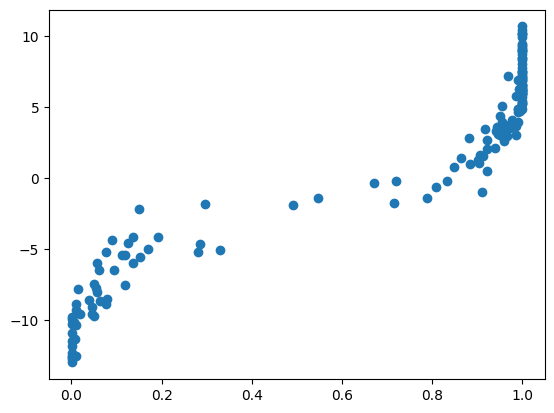

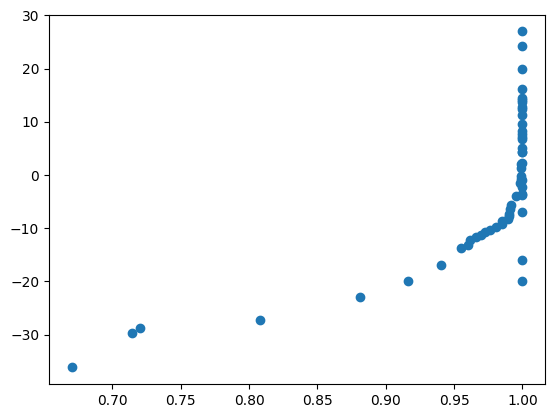

In [82]:
skills_lac = np.take_along_axis(model_lac.predict_class_skills(X_train), y_train[:,np.newaxis], axis=1)
skills_aps = np.take_along_axis(model_aps.predict_class_skills(X_train), y_train[:,np.newaxis], axis=1)
conformity_scores_lac = oracle_annotator_lac.get_conformity(torch.tensor(X_train), torch.tensor(y_train))
conformity_scores_aps = oracle_annotator_aps.get_conformity(torch.tensor(X_train), torch.tensor(y_train))

unique_elements, counts = np.unique(conformity_scores_aps, return_counts=True)
non_unique_elements = unique_elements[counts > 1]
non_unique_indices = np.where(np.isin(conformity_scores_aps, non_unique_elements))[0]

tied_sk = skills_aps[non_unique_indices]
tied_nc = conformity_scores_aps[non_unique_indices]
unique_sk = skills_aps[~non_unique_indices]
unique_nc = conformity_scores_aps[~non_unique_indices]

plt.scatter(conformity_scores_lac, skills_lac)
plt.show()
# plt.scatter(conformity_scores_aps, skills_aps)
plt.scatter(unique_nc, unique_sk)
# plt.scatter(tied_nc, tied_sk, color="orange", label="tie")
plt.show()

In [ ]:
skills_lac = np.take_along_axis(model_lac.predict_class_skills(X_train), y_train[:,np.newaxis], axis=1)
skills_aps = np.take_along_axis(model_aps.predict_class_skills(X_train), y_train[:,np.newaxis], axis=1)
conformity_scores_lac = oracle_annotator_lac.get_conformity(torch.tensor(X_train), torch.tensor(y_train))
conformity_scores_aps = oracle_annotator_aps.get_conformity(torch.tensor(X_train), torch.tensor(y_train))
print("tau lac", kendalltau(conformity_scores_lac, skills_lac))
print("tau aps",kendalltau(conformity_scores_aps, skills_aps))
print("gamma lac", goodman_kruskal_gamma(conformity_scores_lac, skills_lac))
print("gamma aps", goodman_kruskal_gamma(unique_nc.round(4), unique_sk.round(4)))

tau lac SignificanceResult(statistic=0.876359250748282, pvalue=5.242843167939809e-57)
tau aps SignificanceResult(statistic=0.5007534423269919, pvalue=9.343768067764658e-19)
gamma lac 0.8764769065520945
gamma aps 0.6737588652482269


/home/jonas/Documents/Research/torch_plnet/models/ranking_models.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  skills = self.forward(torch.tensor(X, dtype=torch.float32))
/tmp/ipykernel_315728/854360553.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conformity_scores_lac = oracle_annotator_lac.get_conformity(torch.tensor(X_train), torch.tensor(y_train))
/tmp/ipykernel_315728/854360553.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conformity_scores_aps = oracle_annotator_aps.get_conformity(torch.tensor(X_train), torch.te

tau lac SignificanceResult(statistic=0.8036363636363637, pvalue=2.2316998990799488e-32)
tau aps SignificanceResult(statistic=0.4075159127774211, pvalue=1.8911782733571597e-09)
gamma lac 0.8036363636363636
gamma aps 0.40755708223883613


/tmp/ipykernel_315728/519797903.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conformity_scores_lac = oracle_annotator_lac.get_conformity(torch.tensor(X_test), torch.tensor(y_test))
/tmp/ipykernel_315728/519797903.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conformity_scores_aps = oracle_annotator_aps.get_conformity(torch.tensor(X_test), torch.tensor(y_test))


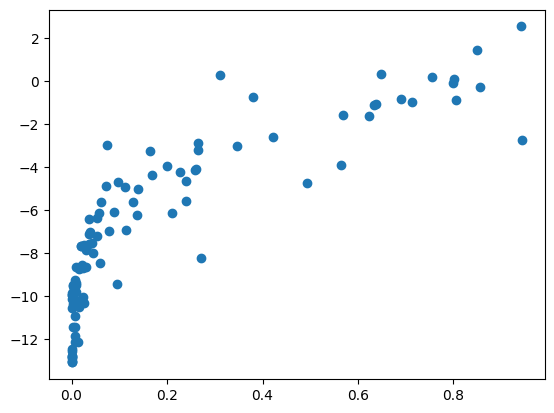

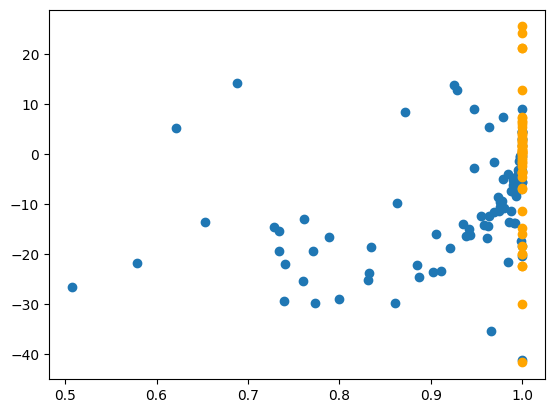

In [77]:
X_test, y_test = clf.generate_data(100)
y_test = y_test.detach().numpy()
skills_lac = np.take_along_axis(model_lac.predict_class_skills(X_test), y_test[:,np.newaxis], axis=1)
skills_aps = np.take_along_axis(model_aps.predict_class_skills(X_test), y_test[:,np.newaxis], axis=1)
conformity_scores_lac = oracle_annotator_lac.get_conformity(torch.tensor(X_test), torch.tensor(y_test))
conformity_scores_aps = oracle_annotator_aps.get_conformity(torch.tensor(X_test), torch.tensor(y_test))
print("tau lac", kendalltau(conformity_scores_lac, skills_lac))
print("tau aps",kendalltau(conformity_scores_aps, skills_aps))
print("gamma lac", goodman_kruskal_gamma(conformity_scores_lac, skills_lac))
print("gamma aps", goodman_kruskal_gamma(conformity_scores_aps, skills_aps))
plt.scatter(conformity_scores_lac, skills_lac)
plt.show()
plt.scatter(conformity_scores_aps, skills_aps)
plt.scatter(tied_nc, tied_sk, color="orange", label="tie")
plt.show()

In [ ]:
num_instances_to_check = np.linspace(10,100,3).astype(int)
# X_train, y_train = make_classification(
#     n_samples=100, n_features=3, n_classes=3, n_informative=3, n_redundant=0, n_repeated=0, n_clusters_per_class=1, random_state=42
# )

clf = clf_2d_2c

clf.fit(None, None)
num_instances_to_check = [50]
tau_corrs_LAC, gamma_corrs_LAC, skills_LAC, conformities_LAC, models_LAC = conduct_oracle_experiment(lac, num_instances_to_check, clf)
tau_corrs_APS, gamma_corrs_APS, skills_APS, conformities_APS, models_APS = conduct_oracle_experiment(aps, num_instances_to_check, clf)

In [98]:
X_test, y_test = clf.generate_data(100)
skills_lac = np.take_along_axis(model_lac.predict_class_skills(X_test), y_test[:,np.newaxis].detach().numpy(), axis=1)
skills_aps = np.take_along_axis(model_aps.predict_class_skills(X_test), y_test[:,np.newaxis].detach().numpy(), axis=1)
conformity_scores_lac = oracle_annotator_lac.get_conformity(torch.tensor(X_test), torch.tensor(y_test))
conformity_scores_aps = oracle_annotator_aps.get_conformity(torch.tensor(X_test), torch.tensor(y_test))
print(kendalltau(conformity_scores_lac, skills_lac))
print(goodman_kruskal_gamma(skills_aps, conformities_APS))

/home/jonas/Documents/Research/torch_plnet/models/ranking_models.py:221: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  skills = self.forward(torch.tensor(X, dtype=torch.float32))
/tmp/ipykernel_300620/2190376619.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conformity_scores_lac = oracle_annotator_lac.get_conformity(torch.tensor(X_test), torch.tensor(y_test))
/tmp/ipykernel_300620/2190376619.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conformity_scores_aps = oracle_annotator_aps.get_conformity(torch.tensor(X_test), torch.t

SignificanceResult(statistic=0.9665745745745746, pvalue=0.0)
0.5816903338884989


In [88]:
conformity_scores_aps = oracle_annotator_aps.get_conformity(torch.tensor(X_test), torch.tensor(y_test))
skills = model_lac.predict_class_skills(X_test)
utilities = np.exp(skills)
# utilities = skills
row_sums = utilities.sum(axis=1, keepdims=True)
utilities_normalized = utilities / row_sums
aps_selfmade = aps(-torch.tensor(utilities),torch.tensor(y_test))
goodman_kruskal_gamma(aps_selfmade, conformity_scores_aps)
kendalltau(aps_selfmade, conformity_scores_aps)

/tmp/ipykernel_300620/3617953157.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conformity_scores_aps = oracle_annotator_aps.get_conformity(torch.tensor(X_test), torch.tensor(y_test))
/tmp/ipykernel_300620/3617953157.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  aps_selfmade = aps(-torch.tensor(utilities),torch.tensor(y_test))


SignificanceResult(statistic=0.25286879132322904, pvalue=3.75167962009967e-32)

In [89]:
len(np.unique(utilities))

2000

In [90]:
np.max(skills)

10.356515

In [91]:
kendalltau(conformity_scores_aps, skills_aps)

SignificanceResult(statistic=0.6044906434746568, pvalue=3.7010786186543696e-175)

Text(0.5, 1.0, 'APS')

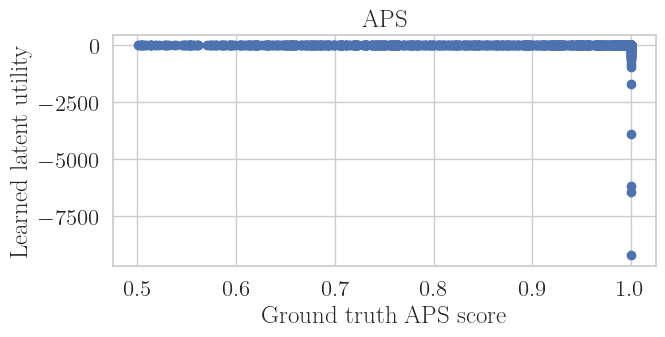

In [92]:
fig,ax = plt.subplots()
ax.scatter(conformity_scores_aps, aps_selfmade)
ax.set_xlabel("Ground truth APS score")
ax.set_ylabel("Learned latent utility")
ax.set_title("APS")

In [93]:
skills_lac.max()

9.127093

Text(0.5, 1.0, 'LAC')

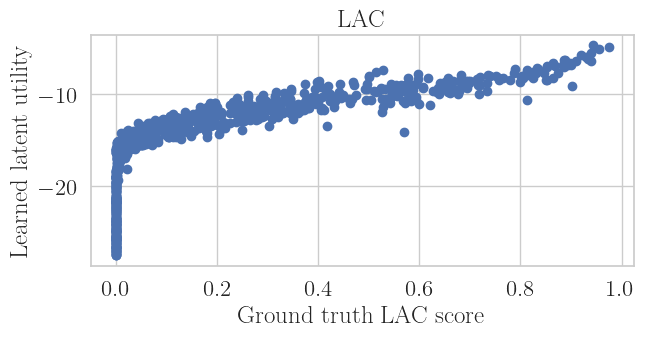

In [18]:
fig,ax = plt.subplots()
ax.scatter(conformity_scores_lac, skills_lac)
ax.set_xlabel("Ground truth LAC score")
ax.set_ylabel("Learned latent utility")
ax.set_title("LAC")

In [38]:
kendalltau(conformity_scores_lac, skills_lac)

SignificanceResult(statistic=0.8815502736776252, pvalue=0.0)

In [20]:
np.min(np.exp(skills_lac))

1.0607849e-12

(array([367., 114.,  74.,  99.,  85.,  99., 117.,  23.,  12.,  10.]),
 array([7.62605555e-09, 9.90023022e-02, 1.98004597e-01, 2.97006891e-01,
        3.96009186e-01, 4.95011480e-01, 5.94013775e-01, 6.93016070e-01,
        7.92018364e-01, 8.91020659e-01, 9.90022953e-01]),
 <BarContainer object of 10 artists>)

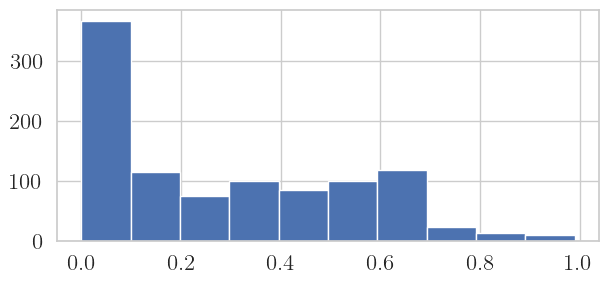

In [21]:
torch.quantile(conformity_scores_aps, q=torch.tensor([0.8]))
from scipy.stats import entropy
plt.hist(entropy(clf.predict_proba(X_test),base=3,axis=1))

(array([367., 114.,  74.,  99.,  85.,  99., 117.,  23.,  12.,  10.]),
 array([7.62605555e-09, 9.90023022e-02, 1.98004597e-01, 2.97006891e-01,
        3.96009186e-01, 4.95011480e-01, 5.94013775e-01, 6.93016070e-01,
        7.92018364e-01, 8.91020659e-01, 9.90022953e-01]),
 <BarContainer object of 10 artists>)

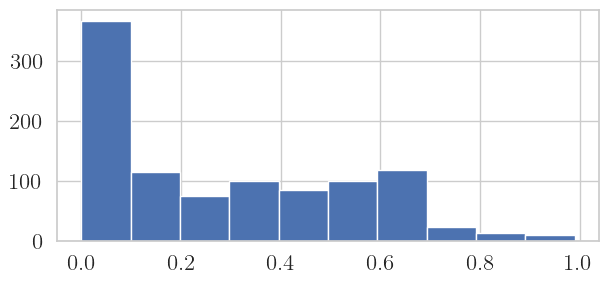

In [22]:
# plt.scatter(conformity_scores, skills_from_model)
from scipy.stats import entropy
probas = clf.predict_proba(X_test)
plt.hist(entropy(probas, base=3, axis=1))

In [23]:

# Initialize and fit the generator
class_params = {
    0: {
        "mean": [3.0, 2.0, 1.0],  # Mean vector for class 0
        "cov": [
            [1.0, 0.5, 0.3],
            [0.5, 1.2, 0.4],
            [0.3, 0.4, 0.8]
        ],  # Covariance matrix for class 0
        "prior": 0.3  # Prior probability for class 0
    },
    1: {
        "mean": [3.0, 4.0, 1.0],  # Mean vector for class 1
        "cov": [
            [1.5, 0.3, 0.2],
            [0.3, 1.1, 0.1],
            [0.2, 0.1, 0.9]
        ],  # Covariance matrix for class 1
        "prior": 0.4  # Prior probability for class 1
    },
    2: {
        "mean": [1.0, 4.0, 4.0],  # Mean vector for class 2
        "cov": [
            [1.2, 0.4, 0.3],
            [0.4, 1.3, 0.5],
            [0.3, 0.5, 1.4]
        ],  # Covariance matrix for class 2
        "prior": 0.3  # Prior probability for class 2
    },
}


clf = TorchMultivariateGaussianClassifier(class_params=class_params, device="cpu")
clf.fit(X_train, y_train)
X_cal, y_cal = clf.generate_data(n_samples=100)

(array([27., 10.,  6.,  5.,  8., 12., 17., 11.,  1.,  3.]),
 array([7.11103604e-07, 8.63128983e-02, 1.72625086e-01, 2.58937273e-01,
        3.45249460e-01, 4.31561647e-01, 5.17873834e-01, 6.04186022e-01,
        6.90498209e-01, 7.76810396e-01, 8.63122583e-01]),
 <BarContainer object of 10 artists>)

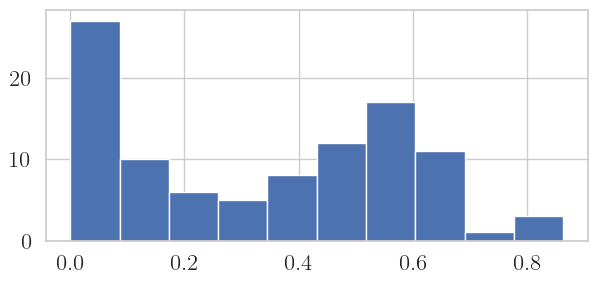

In [24]:
plt.hist(entropy(clf.predict_proba(X_cal),base=3,axis=1))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5,rc={'text.usetex' : True})
sns.set_style("whitegrid")
plt.rc('font', **{'family': 'serif'})
plt.rcParams["figure.figsize"] = (7, 3)



fig, ax = plt.subplots()

ax.set_title("")
ax.set_ylabel(r"Gamma")
ax.set_xlabel(r"No. Instances")
# ax.set_ylim([0.0,1])
# sns.lineplot(x=num_instances_to_check, y=gamma_corrs_LAC, ax = ax, marker="o",label="LAC", legend=False)
# sns.lineplot(x=num_instances_to_check, y=gamma_corrs_APS, ax = ax, marker="o",label="APS", legend=False)
# sns.lineplot(x=num_instances_to_check, y=tau_corrs_TopK, ax = ax, marker="o", label="TopK", legend=False)
lgd = fig.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.08), frameon=False)

fig.tight_layout() 
plt.savefig("replicating.pdf",bbox_extra_artists=(lgd,), bbox_inches='tight')
# axes[1].set_title("APS")
# axes[1].set_ylabel(r"Kendalls $\tau$")
# axes[1].set_xlabel(r"No. Pairs")
# sns.lineplot(x=num_pairs_to_check, y=tau_corrs_APS, ax = axes[1])